In [1]:
from konlpy.tag import Okt,Kkma,Komoran,Mecab,Hannanum
import os
import re

import gensim
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import fasttext
import h5py

import sys
from random import shuffle

from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import MaxPooling1D, Embedding, Dense, Concatenate, Input, Reshape, Bidirectional, LSTM, Flatten, Dropout, Conv1D, Conv2D, MaxPooling2D, GRU, TimeDistributed
from keras.models import Model, Sequential, model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.optimizers import Adam

## Text 전처리

In [2]:
def text_cleaner(text):
        cleantext = []
        publisher = r"\((.*?)\)"
        braces = r"\[(.*?)\]"
        braces2 = r"\{(.*?)\}"
        braces3 = r"\【(.*?)\】"
        writer = r"특파원"
        writer2 = r"기자"
        weird = r"[=_\.,;:~…\"\"\'\'◇%\<\>/·○★☆]"
        tab = r'\t'
        newline = r'\n'
        r=r'\r'
        for line in text:
            try:
                clean = re.sub(writer, '', line)
                clean = re.sub(writer2, '', clean)
                clean = re.sub(publisher,'', clean)
                clean = re.sub(braces,'', clean)
                clean = re.sub(braces2,'', clean)
                clean = re.sub(braces3,'', clean)
                clean = re.sub('[YTN,OSEN]','', clean)
                clean = re.sub(weird,'', clean)
                clean = re.sub(tab,'', clean)
                clean = re.sub(newline,'',clean)
                clean = re.sub(r,'',clean)
                cleantext.append(clean)
            except:
                pass
        return cleantext

### 기사 내용읽는 함수

In [79]:
categoriesFolder = {"정치":0,"경제":1,"사회":2,"생활문화":3,"세계":4,"IT과학":5,"연예":6,"스포츠":7}
Xtrain = []
Ytrain = []
Xtest = []
Ytest = []
Xdata = []
Ydata = []
def readNewsTrainData(categoryName,newsNumber):
    if categoryName=="all":
        for n in range(1,newsNumber+1):
            for folder in categoriesFolder.keys():
                folderName = str(categoriesFolder.get(folder))
                filePath=os.path.join('./newsData',folderName)
                f=open(os.path.join(filePath,folder+str(n)+".txt"),encoding='utf-8')
                try:
                    Xdata.append(f.read())
                except:
                    f=open(os.path.join(filePath,folder+str(n)+".txt"),'rb')
                    Xdata.append(f.read().decode('cp949'))
                Ydata.append(folderName)
                print(str(os.path.join(filePath,folder+str(n)+".txt")+" saved"))

In [80]:
readNewsTrainData("all",200)

./newsData\0\정치1.txt saved
./newsData\1\경제1.txt saved
./newsData\2\사회1.txt saved
./newsData\3\생활문화1.txt saved
./newsData\4\세계1.txt saved
./newsData\5\IT과학1.txt saved
./newsData\6\연예1.txt saved
./newsData\7\스포츠1.txt saved
./newsData\0\정치2.txt saved
./newsData\1\경제2.txt saved
./newsData\2\사회2.txt saved
./newsData\3\생활문화2.txt saved
./newsData\4\세계2.txt saved
./newsData\5\IT과학2.txt saved
./newsData\6\연예2.txt saved
./newsData\7\스포츠2.txt saved
./newsData\0\정치3.txt saved
./newsData\1\경제3.txt saved
./newsData\2\사회3.txt saved
./newsData\3\생활문화3.txt saved
./newsData\4\세계3.txt saved
./newsData\5\IT과학3.txt saved
./newsData\6\연예3.txt saved
./newsData\7\스포츠3.txt saved
./newsData\0\정치4.txt saved
./newsData\1\경제4.txt saved
./newsData\2\사회4.txt saved
./newsData\3\생활문화4.txt saved
./newsData\4\세계4.txt saved
./newsData\5\IT과학4.txt saved
./newsData\6\연예4.txt saved
./newsData\7\스포츠4.txt saved
./newsData\0\정치5.txt saved
./newsData\1\경제5.txt saved
./newsData\2\사회5.txt saved
./newsData\3\생활문화5.txt saved
./news

./newsData\2\사회53.txt saved
./newsData\3\생활문화53.txt saved
./newsData\4\세계53.txt saved
./newsData\5\IT과학53.txt saved
./newsData\6\연예53.txt saved
./newsData\7\스포츠53.txt saved
./newsData\0\정치54.txt saved
./newsData\1\경제54.txt saved
./newsData\2\사회54.txt saved
./newsData\3\생활문화54.txt saved
./newsData\4\세계54.txt saved
./newsData\5\IT과학54.txt saved
./newsData\6\연예54.txt saved
./newsData\7\스포츠54.txt saved
./newsData\0\정치55.txt saved
./newsData\1\경제55.txt saved
./newsData\2\사회55.txt saved
./newsData\3\생활문화55.txt saved
./newsData\4\세계55.txt saved
./newsData\5\IT과학55.txt saved
./newsData\6\연예55.txt saved
./newsData\7\스포츠55.txt saved
./newsData\0\정치56.txt saved
./newsData\1\경제56.txt saved
./newsData\2\사회56.txt saved
./newsData\3\생활문화56.txt saved
./newsData\4\세계56.txt saved
./newsData\5\IT과학56.txt saved
./newsData\6\연예56.txt saved
./newsData\7\스포츠56.txt saved
./newsData\0\정치57.txt saved
./newsData\1\경제57.txt saved
./newsData\2\사회57.txt saved
./newsData\3\생활문화57.txt saved
./newsData\4\세계57.txt save

./newsData\1\경제103.txt saved
./newsData\2\사회103.txt saved
./newsData\3\생활문화103.txt saved
./newsData\4\세계103.txt saved
./newsData\5\IT과학103.txt saved
./newsData\6\연예103.txt saved
./newsData\7\스포츠103.txt saved
./newsData\0\정치104.txt saved
./newsData\1\경제104.txt saved
./newsData\2\사회104.txt saved
./newsData\3\생활문화104.txt saved
./newsData\4\세계104.txt saved
./newsData\5\IT과학104.txt saved
./newsData\6\연예104.txt saved
./newsData\7\스포츠104.txt saved
./newsData\0\정치105.txt saved
./newsData\1\경제105.txt saved
./newsData\2\사회105.txt saved
./newsData\3\생활문화105.txt saved
./newsData\4\세계105.txt saved
./newsData\5\IT과학105.txt saved
./newsData\6\연예105.txt saved
./newsData\7\스포츠105.txt saved
./newsData\0\정치106.txt saved
./newsData\1\경제106.txt saved
./newsData\2\사회106.txt saved
./newsData\3\생활문화106.txt saved
./newsData\4\세계106.txt saved
./newsData\5\IT과학106.txt saved
./newsData\6\연예106.txt saved
./newsData\7\스포츠106.txt saved
./newsData\0\정치107.txt saved
./newsData\1\경제107.txt saved
./newsData\2\사회107.txt 

./newsData\0\정치157.txt saved
./newsData\1\경제157.txt saved
./newsData\2\사회157.txt saved
./newsData\3\생활문화157.txt saved
./newsData\4\세계157.txt saved
./newsData\5\IT과학157.txt saved
./newsData\6\연예157.txt saved
./newsData\7\스포츠157.txt saved
./newsData\0\정치158.txt saved
./newsData\1\경제158.txt saved
./newsData\2\사회158.txt saved
./newsData\3\생활문화158.txt saved
./newsData\4\세계158.txt saved
./newsData\5\IT과학158.txt saved
./newsData\6\연예158.txt saved
./newsData\7\스포츠158.txt saved
./newsData\0\정치159.txt saved
./newsData\1\경제159.txt saved
./newsData\2\사회159.txt saved
./newsData\3\생활문화159.txt saved
./newsData\4\세계159.txt saved
./newsData\5\IT과학159.txt saved
./newsData\6\연예159.txt saved
./newsData\7\스포츠159.txt saved
./newsData\0\정치160.txt saved
./newsData\1\경제160.txt saved
./newsData\2\사회160.txt saved
./newsData\3\생활문화160.txt saved
./newsData\4\세계160.txt saved
./newsData\5\IT과학160.txt saved
./newsData\6\연예160.txt saved
./newsData\7\스포츠160.txt saved
./newsData\0\정치161.txt saved
./newsData\1\경제161.txt 

### train, test로 분할

In [81]:
Ydata2 = list(Ydata)
Xdata2 = list(Xdata)

Xtrain = Xdata2[:1280]
Xtest = Xdata2[1280:]
Ytrain = Ydata2[:1280]
Ytest = Ydata2[1280:]

In [101]:
print(Xtrain)

['美 LA 한인타운서 총격 대치극경찰이 10여명 구출범인 제압    로스앤젤레스 연합뉴스  옥철    미국 캘리포니아주 로스앤젤레스 LA  한인타운에서 총격범이 상점에 난입해 경찰과 대치하다 제압됐다1일 현지시간  현지 KLA 방송 등에 따르면 사건은 전날 오후 한인타운 중심부인 버몬트가와 8가 사이 한 쇼핑몰에서 벌어졌다41세 백인 남성이 담배가게에서 총탄 세 발을 발사했으며 가게 직원 한 명이 발목에 총을 맞아 부상했다용의자는 이어 쇼핑몰 내 상점을 옮겨다니다 잡화류 할인점인 A A 샤인바겐에 숨어들어간 뒤 출동한 경찰과 대치했다 이 상가에는 한인이 운영하는 떡집 등 한인 상점들이 밀집해 있다용의자는 경찰과 4시간가량 대치했다 상점 안에는 고객 10여 명이 공포에 떨며 한동안 갇혀 있었다고 KLA는 전했다LA경찰국 LAPD 은 협상팀을 동원해 용의자에게 투항을 요구했으나 여의치 않자 경찰 특수기동대 WA  요원들을 투입시켰다무장괴한 총격 PG  정연주 제작  일러스트WA 요원들이 사건 발생 4시간 만에 상점에 갇혀 있던 고객들을 구출한 뒤 곧이어 테이저건 등으로 범인을 제압해 체포했다범인이 처음 총을 쏜 가게 점원 외에 다른 부상자는 없었다 발목에 총을 맞은 점원은 병원으로 옮겼으며 생명에 지장이 없는 상태다경찰은 범인이 한인타운 인근에서 자주 목격됐던 인물이라고 말했다LA 한인타운 주변에서는 무장강도  폭행  총격 등 강력 사건이 종종 발생하고 있으며  업주들 사이에서는 LA경찰국 등에 치안 강화 대책을 요구하는 목소리가 커지고 있다', '올댓차이나 대만 13월 172 경제성장 그쳐“I 경기 부진”    서울 뉴시스 이재준    올해 1 3월 분기 대만 실질 경제성장률은 전년 동기 대비 172에 그쳤다고 중국시보 中國時報 가 1일 보도했다신문은 행정원 주계총처 통계청 가 발표한 자료를 인용해 이같이 전하며 2월 시점 예상치를 01 포인트 밑돌면서 11분기 만에 낮은 수준을 기록했다고 지적했다미중 무역전쟁 여파로 주력 정보기술 I  관련 수출이 부진한 것

In [82]:
Xdata = text_cleaner(Xdata)
Xtrain = text_cleaner(Xtrain)
Xtest = text_cleaner(Xtest)

### 명사, 동사를 추출하기 위한 함수

In [7]:
def morphs_process(lines, tagger):
    sentences = []
    for line in lines:
        sentence = []
        po= tagger.pos(line)
        for pair in po:
            if pair[1] in ['Noun','Verb']:
                morpheme = pair[0]
                sentence.append(morpheme)
            else:
                continue
        sentences.append(sentence)
    return sentences

### 정리 된 내용을 txt 파일로 저장

In [8]:
def tokenExport(tokens, filename):
    f = open(filename, 'w')
    f.write('\n')
    for line in tokens:
        f = open(filename, 'a')
        f.writelines(' '.join(line))
        f.write('\n')

### Konlpy의 Tokenizer는 Okt()를 사용함

In [83]:
tokenizer= Okt()

In [84]:
Xtrain = morphs_process(Xtrain, tokenizer)
Xtest = morphs_process(Xtest, tokenizer) 
Xdata = morphs_process(Xdata, tokenizer)

In [35]:
tokenExport(Xtrain, 'tokens.txt')

### ftmodel 준비

In [13]:
def ftmodelmake(data, model, lr = 0.1, dim = 300, ws = 5, min_count = 10):
    model = fasttext.train_unsupervised(data, model, lr = lr, dim = dim, ws = ws, min_count = min_count)
    return model

In [38]:
ftmodel = ftmodelmake('tokens.txt', 'skipgram')
ftmodel.save_model("ftmodel.vec")

In [33]:
from gensim.models.wrappers import FastText
ftModel = KeyedVectors.load_word2vec_format('ftmodel.vec')
ftVocab= list(ftModel.wv.vocab)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [57]:
def ebdIdx(model, vocab_list):
    embd_idx = {}

    for w in vocab_list:
        embd_idx[w] = model.__getitem__(w)

    print(len(embd_idx))
    return embd_idx

In [35]:
embedding_idx = ebdIdx(ftModel, ftVocab)

32707


In [22]:
def getSequence(text, MAX_FEATURES, word_index):
    seq = []
    for line in text:
        lineseq = []
        for i in range(len(line)):
            if (word_index[line[i]] < MAX_FEATURES):
                lineseq.append(word_index[line[i]])
            else:
                pass
        seq.append(lineseq)
    seq = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    seq = np.array(seq)
    return seq

In [ ]:
MAX_FEATURES = len(embedding_idx)
MAX_SEQUENCE_LENGTH = 525
EMBEDDING_DIM = 300
print(MAX_FEATURES)

In [38]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(Xdata)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(Xdata)
seqlen = np.array([len(sequence) for sequence in sequences])
np.histogram(seqlen, bins=50)

(array([146, 221, 387, 318, 201, 116,  66,  43,  29,  20,  18,  10,   4,
          2,   3,   1,   2,   0,   4,   0,   3,   0,   2,   0,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   1,   1,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1], dtype=int64),
 array([   6.  ,   69.06,  132.12,  195.18,  258.24,  321.3 ,  384.36,
         447.42,  510.48,  573.54,  636.6 ,  699.66,  762.72,  825.78,
         888.84,  951.9 , 1014.96, 1078.02, 1141.08, 1204.14, 1267.2 ,
        1330.26, 1393.32, 1456.38, 1519.44, 1582.5 , 1645.56, 1708.62,
        1771.68, 1834.74, 1897.8 , 1960.86, 2023.92, 2086.98, 2150.04,
        2213.1 , 2276.16, 2339.22, 2402.28, 2465.34, 2528.4 , 2591.46,
        2654.52, 2717.58, 2780.64, 2843.7 , 2906.76, 2969.82, 3032.88,
        3095.94, 3159.  ]))

In [ ]:
x_train = getSequence(Xtrain, MAX_FEATURES, word_index)
x_test = getSequence(Xtest, MAX_FEATURES, word_index)
y_train = to_categorical(np.asarray(Ytrain))
y_test = to_categorical(np.asarray(Ytest))

In [134]:
print('Shape of x_train tensor:', x_train.shape)
print('Shape of y_train tensor:', y_train.shape)
print('Shape of x_test tensor:', x_test.shape)
print('Shape of y_test tensor:', y_test.shape)
print(np.amax(x_train))
print(np.amax(y_train))
print(x_train[0])
print(y_train[0])

Shape of x_train tensor: (1280, 525)
Shape of y_train tensor: (1280, 8)
Shape of x_test tensor: (320, 525)
Shape of y_test tensor: (9920, 8)
3105
1.0
[2448 1203   93  745 2245  175   15 2245 2448 1140    6   93 1203  787
   38  176   43  176  146    3  138  210 1056  132  159   40  871   19
 1971  158  937 2021 2529  158 1544 1972 1240 2529  432   19   21 2449
  331  533  816    1  109 1971   73 2623 2719   95 2450   93 1203    1
    8  143    4    3    6   93 1203    1   68  216  571   21 2928   20
   17    1   93  631   66  245  290 1057    6  178 1573   93 1464 2624
 1514 2448 1016  210  299  216   95    3    6  620    1  196  331 2529
  916  153  816 2449  331  542 1694  302   93  894 1973 2022  917   16
    1 1093 2023 2448    3  210  299  871   93  631    3  829 1382  178
    4  737    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    

In [41]:
print('Preparing embedding matrix...')

num_words = min(MAX_FEATURES, len(ftVocab) + 1) #unknown word 때문에 +1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_FEATURES:
        continue
    embedding_vector = embedding_idx.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Preparing embedding matrix...


In [42]:
print(embedding_matrix.shape)

(32707, 300)


### 모델 학습 준비

In [43]:
# path where all models are saved
BASE_PATH = './model_log/'
if not os.path.exists(BASE_PATH):
    os.mkdir(BASE_PATH)

In [64]:
def create_checkpoint(model_name):
    MODEL_PATH = os.path.join(BASE_PATH, model_name)
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)
    
    return ModelCheckpoint(filepath=os.path.join(MODEL_PATH, 'val_loss-{val_loss:.4f}.hdf5'),
                           monitor='val_loss',
                           verbose=1,
                           save_best_only=True)

def create_checkpoint2(model_name):
    MODEL_PATH = os.path.join(BASE_PATH, model_name)
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)
    
    return ModelCheckpoint(filepath=os.path.join(MODEL_PATH, 'val_acc-{val_acc:.4f}.hdf5'),
                           monitor='val_acc',
                           verbose=1,
                           save_best_only=True)

In [186]:
batch_size = 32
max_epochs = 100

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10)

### RNN-LSTM

In [65]:
def LSTMmodel(hiddenlayer = 64, drop = 0.5):
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    dropout = Dropout(drop)(embedded_sequences)

    lstm_1 = Bidirectional(LSTM(hiddenlayer, return_sequences=True))(dropout)
    lstm_2 = Bidirectional(LSTM(hiddenlayer, return_sequences=True))(lstm_1)
    lstm_3 = Bidirectional(LSTM(hiddenlayer, return_sequences=True))(lstm_2)
    lstm_4 = Bidirectional(LSTM(hiddenlayer))(lstm_3)
    preds = Dense(8, activation='softmax')(lstm_4)

    model = Model(sequence_input, preds)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.summary()
    checkloss = create_checkpoint('LSTM') 
    checkacc = create_checkpoint2('LSTM')

    print('Training...')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=max_epochs,
              validation_split=0.15,
              shuffle=True,
              callbacks=[checkloss, checkacc, early_stopping])
    return model, history

### RNN-GRU

In [66]:
def GRUmodel(hiddenlayer = 64, drop = 0.5):
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    dropout = Dropout(drop)(embedded_sequences)

    gru_1 = Bidirectional(GRU(hiddenlayer, return_sequences=True))(dropout)
    gru_2 = Bidirectional(GRU(hiddenlayer, return_sequences=True))(gru_1)
    gru_3 = Bidirectional(GRU(hiddenlayer, return_sequences=True))(gru_2)
    gru_4 = Bidirectional(GRU(hiddenlayer))(gru_3)
    preds = Dense(8, activation='softmax')(gru_4)

    model = Model(sequence_input, preds)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.summary()

    checkloss = create_checkpoint('GRU') 
    checkacc = create_checkpoint2('GRU')
    
    print('Training...')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=max_epochs,
              validation_split = 0.15,
              shuffle=True,
              callbacks=[checkloss, checkacc, early_stopping])
    return model, history

### CNN

In [67]:
def CNNModel(num_filters = 128, drop =0.7):
    filter_sizes = [3,4,5]

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedded_sequences)

    conv_0 = Conv2D(num_filters, 
                    kernel_size=(filter_sizes[0], EMBEDDING_DIM), 
                    padding='valid', 
                    kernel_initializer='normal', 
                    activation='relu')(reshape)
    conv_1 = Conv2D(num_filters, 
                    kernel_size=(filter_sizes[1], EMBEDDING_DIM), 
                    padding='valid', 
                    kernel_initializer='normal', 
                    activation='relu')(reshape)
    conv_2 = Conv2D(num_filters, 
                    kernel_size=(filter_sizes[2], EMBEDDING_DIM), 
                    padding='valid', 
                    kernel_initializer='normal', 
                    activation='relu')(reshape)


    maxpool_0 = MaxPooling2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), 
                             strides=(1,1), 
                             padding='valid')(conv_0)
    maxpool_1 = MaxPooling2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), 
                             strides=(1,1), 
                             padding='valid')(conv_1)
    maxpool_2 = MaxPooling2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), 
                             strides=(1,1), 
                             padding='valid')(conv_2)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
    flatten = Flatten()(concatenated_tensor)
    dropout = Dropout(drop)(flatten)
    preds = Dense(8, activation='softmax')(dropout)

    model = Model(sequence_input, preds)
    model.summary()

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    checkloss = create_checkpoint('CNN') 
    checkacc = create_checkpoint2('CNN')
    
    print('Training...')
    history = model.fit(x_train, y_train, 
              batch_size=batch_size, 
              epochs=max_epochs, 
              verbose=1, 
              shuffle=True,
              callbacks=[checkloss, checkacc, early_stopping], 
              validation_split=0.15) 
    return model, history

In [51]:
lstm = LSTMmodel()

W1203 21:09:09.487157  3760 deprecation.py:506] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1203 21:09:12.437878  3760 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 525)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 525, 300)          9812100   
_________________________________________________________________
dropout_1 (Dropout)          (None, 525, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 525, 128)          186880    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 525, 128)          98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 525, 128)          98816     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               98816     
__________

W1203 21:09:13.198557  3760 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1088 samples, validate on 192 samples
Epoch 1/100
1088/1088 [==============================] - 915s 841ms/step - loss: 1.7505 - acc: 0.3465 - val_loss: 1.3643 - val_acc: 0.5052

Epoch 00001: val_loss improved from inf to 1.36433, saving model to ./model_log/LSTM\val_loss-1.3643.hdf5

Epoch 00001: val_acc improved from -inf to 0.50521, saving model to ./model_log/LSTM\val_acc-0.5052.hdf5
Epoch 2/100
1088/1088 [==============================] - 904s 831ms/step - loss: 1.2443 - acc: 0.5551 - val_loss: 1.0633 - val_acc: 0.5781

Epoch 00002: val_loss improved from 1.36433 to 1.06332, saving model to ./model_log/LSTM\val_loss-1.0633.hdf5

Epoch 00002: val_acc improved from 0.50521 to 0.57812, saving model to ./model_log/LSTM\val_acc-0.5781.hdf5
Epoch 3/100
1088/1088 [==============================] - 760s 699ms/step - loss: 1.0160 - acc: 0.6039 - val_loss: 1.0105 - val_acc: 0.6250

Epoch 00003: val_loss improved from 1.06332 to 1.01046, saving model to ./model_log/LSTM\val_loss-1.01

In [53]:
gru = GRUmodel()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 525)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 525, 300)          9812100   
_________________________________________________________________
dropout_2 (Dropout)          (None, 525, 300)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 525, 128)          140160    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 525, 128)          74112     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               74112     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
Total para

In [55]:
cnn = CNNModel()

W1204 14:10:41.584300  3760 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1204 14:10:44.219076  3760 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 525)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 525, 300)     9812100     input_4[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 525, 300, 1)  0           embedding_2[2][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 523, 1, 128)  115328      reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (

1088/1088 [==============================] - 6s 6ms/step - loss: 0.2432 - acc: 0.9301 - val_loss: 0.7337 - val_acc: 0.7969

Epoch 00017: val_loss did not improve from 0.73316

Epoch 00017: val_acc did not improve from 0.80208
Epoch 18/100
1088/1088 [==============================] - 6s 6ms/step - loss: 0.2248 - acc: 0.9375 - val_loss: 0.7227 - val_acc: 0.7812

Epoch 00018: val_loss improved from 0.73316 to 0.72272, saving model to ./model_log/CNN\val_loss-0.7227.hdf5

Epoch 00018: val_acc did not improve from 0.80208
Epoch 19/100
1088/1088 [==============================] - 6s 6ms/step - loss: 0.2109 - acc: 0.9531 - val_loss: 0.7329 - val_acc: 0.7865

Epoch 00019: val_loss did not improve from 0.72272

Epoch 00019: val_acc did not improve from 0.80208
Epoch 20/100
1088/1088 [==============================] - 6s 6ms/step - loss: 0.1895 - acc: 0.9467 - val_loss: 0.7133 - val_acc: 0.7865

Epoch 00020: val_loss improved from 0.72272 to 0.71333, saving model to ./model_log/CNN\val_loss-0.71

### loss, 정확도 출력 함수

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_train(history):
    fig, loss_ax = plt.subplots(figsize=(6,6))
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.set_ylim([0.0, 3.0])

    acc_ax.plot(history.history['acc'], 'b', label='train acc')
    acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
    acc_ax.set_ylim([0.0, 1.1])

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuray')

    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()
    
def test_summary(model, weight_path):
    plot_train(model[1])
    model[0].load_weights(weight_path)
    loss, acc = model[0].evaluate(x_test, y_test, batch_size=batch_size)
    print('----- Evaluation loss and metrics -----')
    print('Test loss:', loss)
    print('Test accuracy:', acc)
    
def saveModel(model, name):
    model_json = model[0].to_json()
    with open(name, "w") as json_file:
        json_file.write(model_json)

def loadModel(modelfile, weightfile):
    json_file = open(modelfile, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(weightfile)
    loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return loaded_model

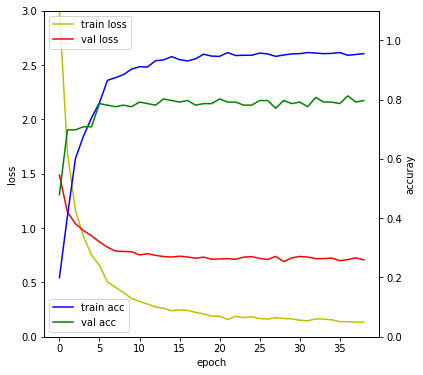

320/320 [==============================] - 1s 2ms/step
----- Evaluation loss and metrics -----
Test loss: 0.6438247978687286
Test accuracy: 0.803125


In [57]:
test_summary(cnn,'./model_log/CNN/val_loss-0.6915.hdf5')

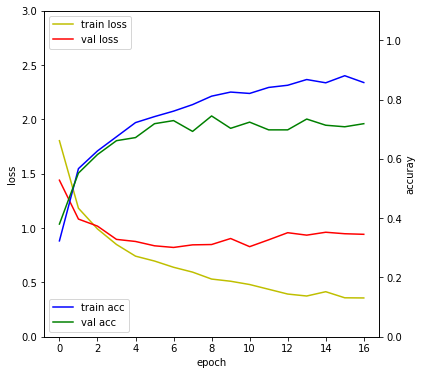

320/320 [==============================] - 26s 81ms/step
----- Evaluation loss and metrics -----
Test loss: 0.8294383078813553
Test accuracy: 0.73125


In [60]:
test_summary(gru,'./model_log/GRU/val_loss-0.8219.hdf5')

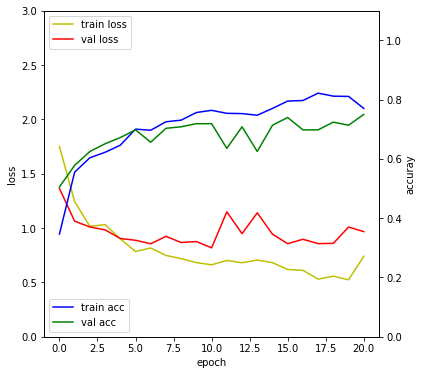

320/320 [==============================] - 38s 118ms/step
----- Evaluation loss and metrics -----
Test loss: 0.8514702618122101
Test accuracy: 0.715625


In [61]:
test_summary(lstm,'./model_log/LSTM/val_loss-0.8181.hdf5')

### word2vec 생성을 위한 데이터 읽기

In [69]:
readNewsTrainData("all",200)

./newsData\0\정치1.txt saved
./newsData\1\경제1.txt saved
./newsData\2\사회1.txt saved
./newsData\3\생활문화1.txt saved
./newsData\4\세계1.txt saved
./newsData\5\IT과학1.txt saved
./newsData\6\연예1.txt saved
./newsData\7\스포츠1.txt saved
./newsData\0\정치2.txt saved
./newsData\1\경제2.txt saved
./newsData\2\사회2.txt saved
./newsData\3\생활문화2.txt saved
./newsData\4\세계2.txt saved
./newsData\5\IT과학2.txt saved
./newsData\6\연예2.txt saved
./newsData\7\스포츠2.txt saved
./newsData\0\정치3.txt saved
./newsData\1\경제3.txt saved
./newsData\2\사회3.txt saved
./newsData\3\생활문화3.txt saved
./newsData\4\세계3.txt saved
./newsData\5\IT과학3.txt saved
./newsData\6\연예3.txt saved
./newsData\7\스포츠3.txt saved
./newsData\0\정치4.txt saved
./newsData\1\경제4.txt saved
./newsData\2\사회4.txt saved
./newsData\3\생활문화4.txt saved
./newsData\4\세계4.txt saved
./newsData\5\IT과학4.txt saved
./newsData\6\연예4.txt saved
./newsData\7\스포츠4.txt saved
./newsData\0\정치5.txt saved
./newsData\1\경제5.txt saved
./newsData\2\사회5.txt saved
./newsData\3\생활문화5.txt saved
./news

./newsData\7\스포츠53.txt saved
./newsData\0\정치54.txt saved
./newsData\1\경제54.txt saved
./newsData\2\사회54.txt saved
./newsData\3\생활문화54.txt saved
./newsData\4\세계54.txt saved
./newsData\5\IT과학54.txt saved
./newsData\6\연예54.txt saved
./newsData\7\스포츠54.txt saved
./newsData\0\정치55.txt saved
./newsData\1\경제55.txt saved
./newsData\2\사회55.txt saved
./newsData\3\생활문화55.txt saved
./newsData\4\세계55.txt saved
./newsData\5\IT과학55.txt saved
./newsData\6\연예55.txt saved
./newsData\7\스포츠55.txt saved
./newsData\0\정치56.txt saved
./newsData\1\경제56.txt saved
./newsData\2\사회56.txt saved
./newsData\3\생활문화56.txt saved
./newsData\4\세계56.txt saved
./newsData\5\IT과학56.txt saved
./newsData\6\연예56.txt saved
./newsData\7\스포츠56.txt saved
./newsData\0\정치57.txt saved
./newsData\1\경제57.txt saved
./newsData\2\사회57.txt saved
./newsData\3\생활문화57.txt saved
./newsData\4\세계57.txt saved
./newsData\5\IT과학57.txt saved
./newsData\6\연예57.txt saved
./newsData\7\스포츠57.txt saved
./newsData\0\정치58.txt saved
./newsData\1\경제58.txt saved

./newsData\0\정치110.txt saved
./newsData\1\경제110.txt saved
./newsData\2\사회110.txt saved
./newsData\3\생활문화110.txt saved
./newsData\4\세계110.txt saved
./newsData\5\IT과학110.txt saved
./newsData\6\연예110.txt saved
./newsData\7\스포츠110.txt saved
./newsData\0\정치111.txt saved
./newsData\1\경제111.txt saved
./newsData\2\사회111.txt saved
./newsData\3\생활문화111.txt saved
./newsData\4\세계111.txt saved
./newsData\5\IT과학111.txt saved
./newsData\6\연예111.txt saved
./newsData\7\스포츠111.txt saved
./newsData\0\정치112.txt saved
./newsData\1\경제112.txt saved
./newsData\2\사회112.txt saved
./newsData\3\생활문화112.txt saved
./newsData\4\세계112.txt saved
./newsData\5\IT과학112.txt saved
./newsData\6\연예112.txt saved
./newsData\7\스포츠112.txt saved
./newsData\0\정치113.txt saved
./newsData\1\경제113.txt saved
./newsData\2\사회113.txt saved
./newsData\3\생활문화113.txt saved
./newsData\4\세계113.txt saved
./newsData\5\IT과학113.txt saved
./newsData\6\연예113.txt saved
./newsData\7\스포츠113.txt saved
./newsData\0\정치114.txt saved
./newsData\1\경제114.txt 

./newsData\5\IT과학164.txt saved
./newsData\6\연예164.txt saved
./newsData\7\스포츠164.txt saved
./newsData\0\정치165.txt saved
./newsData\1\경제165.txt saved
./newsData\2\사회165.txt saved
./newsData\3\생활문화165.txt saved
./newsData\4\세계165.txt saved
./newsData\5\IT과학165.txt saved
./newsData\6\연예165.txt saved
./newsData\7\스포츠165.txt saved
./newsData\0\정치166.txt saved
./newsData\1\경제166.txt saved
./newsData\2\사회166.txt saved
./newsData\3\생활문화166.txt saved
./newsData\4\세계166.txt saved
./newsData\5\IT과학166.txt saved
./newsData\6\연예166.txt saved
./newsData\7\스포츠166.txt saved
./newsData\0\정치167.txt saved
./newsData\1\경제167.txt saved
./newsData\2\사회167.txt saved
./newsData\3\생활문화167.txt saved
./newsData\4\세계167.txt saved
./newsData\5\IT과학167.txt saved
./newsData\6\연예167.txt saved
./newsData\7\스포츠167.txt saved
./newsData\0\정치168.txt saved
./newsData\1\경제168.txt saved
./newsData\2\사회168.txt saved
./newsData\3\생활문화168.txt saved
./newsData\4\세계168.txt saved
./newsData\5\IT과학168.txt saved
./newsData\6\연예168.tx

In [70]:
Ydata2 = list(Ydata)
Xdata2 = list(Xdata)

Xtrain = Xdata2[:1280]
Xtest = Xdata2[1280:]
Ytrain = Ydata2[:1280]
Ytest = Ydata2[1280:]

In [71]:
Xdata = text_cleaner(Xdata)
Xtrain = text_cleaner(Xtrain)
Xtest = text_cleaner(Xtest)

In [72]:
tokenizer= Okt()

In [73]:
Xtrain = morphs_process(Xtrain, tokenizer)
Xtest = morphs_process(Xtest, tokenizer) 
Xdata = morphs_process(Xdata, tokenizer)

In [47]:
def tokenExport(tokens, filename):
    f = open(filename, 'w')
    f.write('\n')
    for line in tokens:
        f = open(filename, 'a')
        f.writelines(' '.join(line))
        f.write('\n')

In [48]:
tokenExport(Xtrain, 'tokensw2v.txt')

In [54]:
from gensim.models import Word2Vec
embedding_model2 = Word2Vec(Xdata,size=300, window=5, min_count=10, workers=1)

In [55]:
w2vVocab=list(embedding_model2.wv.vocab)

In [58]:
embedding_idx2 = ebdIdx(embedding_model2, w2vVocab)

15515


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [59]:
MAX_FEATURES = len(embedding_idx2)
MAX_SEQUENCE_LENGTH = 525
EMBEDDING_DIM = 300
print(MAX_FEATURES)

15515


In [60]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(Xdata)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(Xdata)
seqlen = np.array([len(sequence) for sequence in sequences])
np.histogram(seqlen, bins=50)

(array([ 925, 1410, 1911, 1436,  907,  567,  316,  185,  113,   65,   49,
          22,   18,   13,   10,    5,    7,    7,    3,    4,    1,    4,
           3,    2,    1,    3,    0,    0,    2,    0,    2,    1,    0,
           0,    0,    0,    0,    0,    1,    0,    1,    0,    0,    0,
           0,    1,    0,    2,    0,    3], dtype=int64),
 array([3.0000e+00, 6.8800e+01, 1.3460e+02, 2.0040e+02, 2.6620e+02,
        3.3200e+02, 3.9780e+02, 4.6360e+02, 5.2940e+02, 5.9520e+02,
        6.6100e+02, 7.2680e+02, 7.9260e+02, 8.5840e+02, 9.2420e+02,
        9.9000e+02, 1.0558e+03, 1.1216e+03, 1.1874e+03, 1.2532e+03,
        1.3190e+03, 1.3848e+03, 1.4506e+03, 1.5164e+03, 1.5822e+03,
        1.6480e+03, 1.7138e+03, 1.7796e+03, 1.8454e+03, 1.9112e+03,
        1.9770e+03, 2.0428e+03, 2.1086e+03, 2.1744e+03, 2.2402e+03,
        2.3060e+03, 2.3718e+03, 2.4376e+03, 2.5034e+03, 2.5692e+03,
        2.6350e+03, 2.7008e+03, 2.7666e+03, 2.8324e+03, 2.8982e+03,
        2.9640e+03, 3.0298e+03, 3

In [85]:
x_train = getSequence(Xtrain, MAX_FEATURES, word_index)
x_test = getSequence(Xtest, MAX_FEATURES, word_index)
y_train = to_categorical(np.asarray(Ytrain))
y_test = to_categorical(np.asarray(Ytest))

In [62]:
print('Preparing embedding matrix...')

num_words = min(MAX_FEATURES, len(w2vVocab) + 1) #unknown word 때문에 +1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_FEATURES:
        continue
    embedding_vector = embedding_idx2.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Preparing embedding matrix...


In [63]:
print(embedding_matrix.shape)

(15515, 300)


### word2vec 학습 모델 준비

In [64]:
# path where all models are saved
BASE_PATH = './model_log_w2v/'
if not os.path.exists(BASE_PATH):
    os.mkdir(BASE_PATH)

### CNN

In [78]:
print(len(Xtest))

1600


In [86]:
cnn = CNNModel()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 525)          0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 525, 300)     4654500     input_11[0][0]                   
__________________________________________________________________________________________________
reshape_9 (Reshape)             (None, 525, 300, 1)  0           embedding_10[2][0]               
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 523, 1, 128)  115328      reshape_9[0][0]                  
__________________________________________________________________________________________________
conv2d_25 

1088/1088 [==============================] - 6s 6ms/step - loss: 0.3693 - acc: 0.8778 - val_loss: 0.7724 - val_acc: 0.7135

Epoch 00017: val_loss did not improve from 0.74978

Epoch 00017: val_acc did not improve from 0.72917
Epoch 18/100
1088/1088 [==============================] - 6s 6ms/step - loss: 0.3669 - acc: 0.8658 - val_loss: 0.8012 - val_acc: 0.7031

Epoch 00018: val_loss did not improve from 0.74978

Epoch 00018: val_acc did not improve from 0.72917
Epoch 19/100
1088/1088 [==============================] - 6s 6ms/step - loss: 0.3855 - acc: 0.8686 - val_loss: 0.7942 - val_acc: 0.7188

Epoch 00019: val_loss did not improve from 0.74978

Epoch 00019: val_acc did not improve from 0.72917
Epoch 20/100
1088/1088 [==============================] - 6s 6ms/step - loss: 0.3488 - acc: 0.8824 - val_loss: 0.7932 - val_acc: 0.6927

Epoch 00020: val_loss did not improve from 0.74978

Epoch 00020: val_acc did not improve from 0.72917
Epoch 21/100
1088/1088 [==============================] -

### GRU

In [87]:
gru = GRUmodel()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 525)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 525, 300)          4654500   
_________________________________________________________________
dropout_12 (Dropout)         (None, 525, 300)          0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 525, 128)          140160    
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 525, 128)          74112     
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 525, 128)          74112     
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 128)               74112     
__________

### LSTM

In [88]:
lstm = LSTMmodel()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 525)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 525, 300)          4654500   
_________________________________________________________________
dropout_13 (Dropout)         (None, 525, 300)          0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 525, 128)          186880    
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 525, 128)          98816     
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 525, 128)          98816     
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 128)               98816     
__________

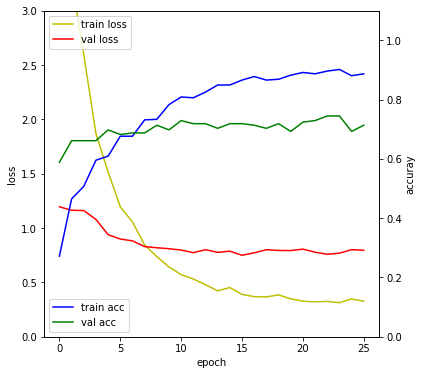

320/320 [==============================] - 0s 1ms/step
----- Evaluation loss and metrics -----
Test loss: 0.6999307781457901
Test accuracy: 0.75


In [89]:
test_summary(cnn,'./model_log_w2v/CNN/val_loss-0.7498.hdf5')

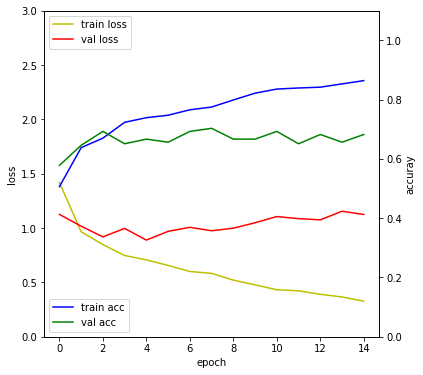

320/320 [==============================] - 15s 48ms/step
----- Evaluation loss and metrics -----
Test loss: 0.7981161832809448
Test accuracy: 0.690625


In [90]:
test_summary(gru,'./model_log_w2v/GRU/val_loss-0.8894.hdf5')

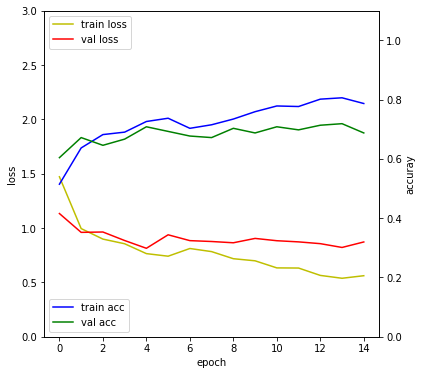

320/320 [==============================] - 29s 90ms/step
----- Evaluation loss and metrics -----
Test loss: 0.8300825119018554
Test accuracy: 0.69375


In [91]:
test_summary(lstm,'./model_log_w2v/LSTM/val_loss-0.8141.hdf5')

### Lookup Table 구축

In [11]:
from keras.preprocessing.text import Tokenizer
t=Tokenizer()
t.fit_on_texts(Xtrain)
vocab_size=len(t.word_index)+1

In [12]:
print(vocab_size)

26772


In [15]:
MAX_SEQUENCE_LENGTH = 525
EMBEDDING_DIM = 300

In [32]:
tokenizer = Tokenizer(num_words=30000)
tokenizer.fit_on_texts(Xdata)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(Xdata)
seqlen = np.array([len(sequence) for sequence in sequences])
np.histogram(seqlen, bins=50)

(array([146, 221, 387, 318, 201, 116,  66,  43,  29,  20,  18,  10,   4,
          2,   3,   1,   2,   0,   4,   0,   3,   0,   2,   0,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   1,   1,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1], dtype=int64),
 array([   6.  ,   69.06,  132.12,  195.18,  258.24,  321.3 ,  384.36,
         447.42,  510.48,  573.54,  636.6 ,  699.66,  762.72,  825.78,
         888.84,  951.9 , 1014.96, 1078.02, 1141.08, 1204.14, 1267.2 ,
        1330.26, 1393.32, 1456.38, 1519.44, 1582.5 , 1645.56, 1708.62,
        1771.68, 1834.74, 1897.8 , 1960.86, 2023.92, 2086.98, 2150.04,
        2213.1 , 2276.16, 2339.22, 2402.28, 2465.34, 2528.4 , 2591.46,
        2654.52, 2717.58, 2780.64, 2843.7 , 2906.76, 2969.82, 3032.88,
        3095.94, 3159.  ]))

In [33]:
x_train = getSequence(Xtrain, 30000, word_index)
x_test = getSequence(Xtest, 30000, word_index)
y_train = to_categorical(np.asarray(Ytrain))
y_test = to_categorical(np.asarray(Ytest))

In [43]:
batch_size = 32
max_epochs = 100

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10)

In [13]:
# path where all models are saved
BASE_PATH = './model_log_look_up/'
if not os.path.exists(BASE_PATH):
    os.mkdir(BASE_PATH)

In [41]:
def LSTMmodel(hiddenlayer = 64, drop = 0.5):
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = Embedding(output_dim=300,input_dim=vocab_size,trainable=False)(sequence_input)
    dropout = Dropout(drop)(embedded_sequences)

    lstm_1 = Bidirectional(LSTM(hiddenlayer, return_sequences=True))(dropout)
    lstm_2 = Bidirectional(LSTM(hiddenlayer, return_sequences=True))(lstm_1)
    lstm_3 = Bidirectional(LSTM(hiddenlayer, return_sequences=True))(lstm_2)
    lstm_4 = Bidirectional(LSTM(hiddenlayer))(lstm_3)
    preds = Dense(8, activation='softmax')(lstm_4)

    model = Model(sequence_input, preds)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.summary()
    checkloss = create_checkpoint('LSTM') 
    checkacc = create_checkpoint2('LSTM')

    print('Training...')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=max_epochs,
              validation_split=0.15,
              shuffle=True,
              callbacks=[checkloss, checkacc, early_stopping])
    return model, history

In [42]:
lstm=LSTMmodel()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 525)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 525, 300)          8031600   
_________________________________________________________________
dropout_8 (Dropout)          (None, 525, 300)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 525, 128)          186880    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 525, 128)          98816     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 525, 128)          98816     
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 128)               98816     
__________

1088/1088 [==============================] - 292s 268ms/step - loss: 1.0623 - acc: 0.5983 - val_loss: 1.4349 - val_acc: 0.5052

Epoch 00023: val_loss did not improve from 1.36020

Epoch 00023: val_acc did not improve from 0.53125
Epoch 24/100
1088/1088 [==============================] - 293s 269ms/step - loss: 1.0570 - acc: 0.6149 - val_loss: 1.2776 - val_acc: 0.5156

Epoch 00024: val_loss improved from 1.36020 to 1.27761, saving model to ./model_log_look_up/LSTM\val_loss-1.2776.hdf5

Epoch 00024: val_acc did not improve from 0.53125
Epoch 25/100
1088/1088 [==============================] - 302s 278ms/step - loss: 0.9709 - acc: 0.6388 - val_loss: 1.3286 - val_acc: 0.5104

Epoch 00025: val_loss did not improve from 1.27761

Epoch 00025: val_acc did not improve from 0.53125
Epoch 26/100
1088/1088 [==============================] - 302s 278ms/step - loss: 0.9765 - acc: 0.6406 - val_loss: 1.3594 - val_acc: 0.5260

Epoch 00026: val_loss did not improve from 1.27761

Epoch 00026: val_acc did

In [38]:
def GRUmodel(hiddenlayer = 64, drop = 0.5):
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = Embedding(output_dim=300,input_dim=vocab_size,trainable=False)(sequence_input)
    dropout = Dropout(drop)(embedded_sequences)

    gru_1 = Bidirectional(GRU(hiddenlayer, return_sequences=True))(dropout)
    gru_2 = Bidirectional(GRU(hiddenlayer, return_sequences=True))(gru_1)
    gru_3 = Bidirectional(GRU(hiddenlayer, return_sequences=True))(gru_2)
    gru_4 = Bidirectional(GRU(hiddenlayer))(gru_3)
    preds = Dense(8, activation='softmax')(gru_4)

    model = Model(sequence_input, preds)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.summary()

    checkloss = create_checkpoint('GRU') 
    checkacc = create_checkpoint2('GRU')
    
    print('Training...')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=max_epochs,
              validation_split = 0.15,
              shuffle=True,
              callbacks=[checkloss, checkacc, early_stopping])
    return model, history

In [39]:
gru=GRUmodel()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 525)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 525, 300)          8031600   
_________________________________________________________________
dropout_7 (Dropout)          (None, 525, 300)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 525, 128)          140160    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 525, 128)          74112     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 525, 128)          74112     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 128)               74112     
__________

1088/1088 [==============================] - 296s 272ms/step - loss: 0.8169 - acc: 0.7013 - val_loss: 1.5491 - val_acc: 0.5260

Epoch 00023: val_loss did not improve from 1.47654

Epoch 00023: val_acc improved from 0.47917 to 0.52604, saving model to ./model_log_look_up/GRU\val_acc-0.5260.hdf5
Epoch 24/100
1088/1088 [==============================] - 297s 273ms/step - loss: 0.7586 - acc: 0.7344 - val_loss: 1.6539 - val_acc: 0.4427

Epoch 00024: val_loss did not improve from 1.47654

Epoch 00024: val_acc did not improve from 0.52604
Epoch 25/100
1088/1088 [==============================] - 299s 275ms/step - loss: 0.8209 - acc: 0.7013 - val_loss: 1.6960 - val_acc: 0.4010

Epoch 00025: val_loss did not improve from 1.47654

Epoch 00025: val_acc did not improve from 0.52604


In [17]:
def CNNModel(num_filters = 128, drop =0.7):
    filter_sizes = [3,4,5]

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = Embedding(output_dim=300,input_dim=vocab_size,trainable=False)(sequence_input)
    reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedded_sequences)

    conv_0 = Conv2D(num_filters, 
                    kernel_size=(filter_sizes[0], EMBEDDING_DIM), 
                    padding='valid', 
                    kernel_initializer='normal', 
                    activation='relu')(reshape)
    conv_1 = Conv2D(num_filters, 
                    kernel_size=(filter_sizes[1], EMBEDDING_DIM), 
                    padding='valid', 
                    kernel_initializer='normal', 
                    activation='relu')(reshape)
    conv_2 = Conv2D(num_filters, 
                    kernel_size=(filter_sizes[2], EMBEDDING_DIM), 
                    padding='valid', 
                    kernel_initializer='normal', 
                    activation='relu')(reshape)


    maxpool_0 = MaxPooling2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), 
                             strides=(1,1), 
                             padding='valid')(conv_0)
    maxpool_1 = MaxPooling2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), 
                             strides=(1,1), 
                             padding='valid')(conv_1)
    maxpool_2 = MaxPooling2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), 
                             strides=(1,1), 
                             padding='valid')(conv_2)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
    flatten = Flatten()(concatenated_tensor)
    dropout = Dropout(drop)(flatten)
    preds = Dense(8, activation='softmax')(dropout)

    model = Model(sequence_input, preds)
    model.summary()

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    checkloss = create_checkpoint('CNN') 
    checkacc = create_checkpoint2('CNN')
    
    print('Training...')
    history = model.fit(x_train, y_train, 
              batch_size=batch_size, 
              epochs=max_epochs, 
              verbose=1, 
              shuffle=True,
              callbacks=[checkloss, checkacc, early_stopping], 
              validation_split=0.15) 
    return model, history

In [35]:
cnn=CNNModel()

W1207 15:17:55.320388 25120 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 525)          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 525, 300)     8031600     input_5[0][0]                    
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 525, 300, 1)  0           embedding_6[0][0]                
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 523, 1, 128)  115328      reshape_6[0][0]                  
__________________________________________________________________________________________________
conv2d_16 

1088/1088 [==============================] - 5s 5ms/step - loss: 0.7458 - acc: 0.8281 - val_loss: 1.1567 - val_acc: 0.7240

Epoch 00015: val_loss improved from 1.18765 to 1.15675, saving model to ./model_log_look_up/CNN\val_loss-1.1567.hdf5

Epoch 00015: val_acc improved from 0.71875 to 0.72396, saving model to ./model_log_look_up/CNN\val_acc-0.7240.hdf5
Epoch 16/100
1088/1088 [==============================] - 5s 5ms/step - loss: 0.6679 - acc: 0.8575 - val_loss: 1.1224 - val_acc: 0.7396

Epoch 00016: val_loss improved from 1.15675 to 1.12236, saving model to ./model_log_look_up/CNN\val_loss-1.1224.hdf5

Epoch 00016: val_acc improved from 0.72396 to 0.73958, saving model to ./model_log_look_up/CNN\val_acc-0.7396.hdf5
Epoch 17/100
1088/1088 [==============================] - 5s 5ms/step - loss: 0.6319 - acc: 0.8667 - val_loss: 1.0956 - val_acc: 0.7448

Epoch 00017: val_loss improved from 1.12236 to 1.09555, saving model to ./model_log_look_up/CNN\val_loss-1.0956.hdf5

Epoch 00017: val_a

1088/1088 [==============================] - 6s 5ms/step - loss: 0.1648 - acc: 0.9642 - val_loss: 0.8690 - val_acc: 0.7604

Epoch 00042: val_loss improved from 0.87513 to 0.86901, saving model to ./model_log_look_up/CNN\val_loss-0.8690.hdf5

Epoch 00042: val_acc did not improve from 0.76562
Epoch 43/100
1088/1088 [==============================] - 6s 5ms/step - loss: 0.1661 - acc: 0.9651 - val_loss: 0.8675 - val_acc: 0.7604

Epoch 00043: val_loss improved from 0.86901 to 0.86747, saving model to ./model_log_look_up/CNN\val_loss-0.8675.hdf5

Epoch 00043: val_acc did not improve from 0.76562
Epoch 44/100
1088/1088 [==============================] - 5s 5ms/step - loss: 0.1722 - acc: 0.9522 - val_loss: 0.8679 - val_acc: 0.7552

Epoch 00044: val_loss did not improve from 0.86747

Epoch 00044: val_acc did not improve from 0.76562
Epoch 45/100
1088/1088 [==============================] - 6s 5ms/step - loss: 0.1530 - acc: 0.9614 - val_loss: 0.8611 - val_acc: 0.7552

Epoch 00045: val_loss impro

1088/1088 [==============================] - 5s 5ms/step - loss: 0.1213 - acc: 0.9550 - val_loss: 0.8595 - val_acc: 0.7604

Epoch 00073: val_loss did not improve from 0.83662

Epoch 00073: val_acc did not improve from 0.77604
Epoch 74/100
1088/1088 [==============================] - 5s 5ms/step - loss: 0.1224 - acc: 0.9568 - val_loss: 0.8520 - val_acc: 0.7656

Epoch 00074: val_loss did not improve from 0.83662

Epoch 00074: val_acc did not improve from 0.77604
Epoch 75/100
1088/1088 [==============================] - 5s 5ms/step - loss: 0.1254 - acc: 0.9596 - val_loss: 0.8497 - val_acc: 0.7604

Epoch 00075: val_loss did not improve from 0.83662

Epoch 00075: val_acc did not improve from 0.77604
Epoch 76/100
1088/1088 [==============================] - 5s 5ms/step - loss: 0.1232 - acc: 0.9614 - val_loss: 0.8413 - val_acc: 0.7552

Epoch 00076: val_loss did not improve from 0.83662

Epoch 00076: val_acc did not improve from 0.77604
Epoch 77/100
1088/1088 [==============================] -

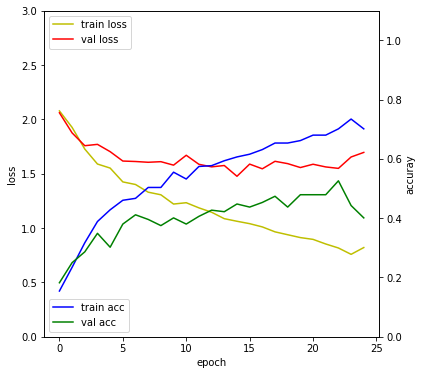

320/320 [==============================] - 33s 103ms/step
----- Evaluation loss and metrics -----
Test loss: 1.3749763369560242
Test accuracy: 0.528125


In [48]:
test_summary(gru,'./model_log_look_up/GRU/val_loss-1.4765.hdf5')

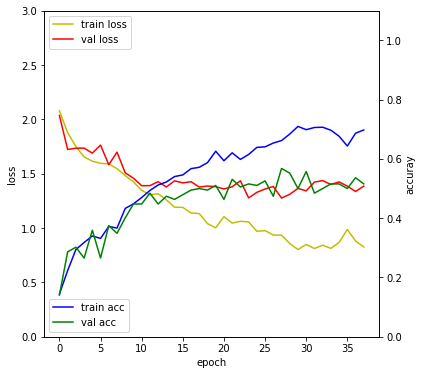

320/320 [==============================] - 38s 120ms/step
----- Evaluation loss and metrics -----
Test loss: 1.169988489151001
Test accuracy: 0.575


In [46]:
test_summary(lstm,'./model_log_look_up/LSTM/val_loss-1.2760.hdf5')

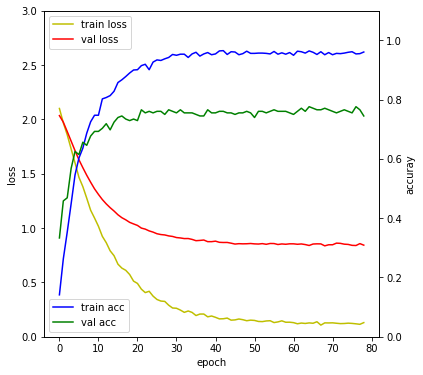

320/320 [==============================] - 1s 2ms/step
----- Evaluation loss and metrics -----
Test loss: 0.7934934437274933
Test accuracy: 0.7375


In [45]:
test_summary(cnn,'./model_log_look_up/CNN/val_loss-0.8366.hdf5')